# Fire Hazard Incidents Analytics Pipeline
## Firefighter Severity vs Time taken to control Fire

## Importing Required Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

from storedb import save_in_db, IMG_PATH

## Creating Spark Session and using all available cores

In [2]:
%%time
spark = SparkSession \
    .builder \
    .appName("532: Project") \
    .config("local[4]") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/11 20:43:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/11 20:43:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/12/11 20:43:04 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/12/11 20:43:04 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
CPU times: user 19.3 ms, sys: 22.1 ms, total: 41.4 ms
Wall time: 2.29 s


## Loading firefighter casuality and basic module data

In [3]:
%%time
firefighter_casualities_df = spark.read.options(delimiter="^", header=True).csv("ffcasualty.txt")
basic_module_df = spark.read.options(delimiter="^", header=True).csv("basicincident.txt")

CPU times: user 3.97 ms, sys: 2.91 ms, total: 6.89 ms
Wall time: 2.92 s


In [4]:
%%time
# Formatting datetime columns
basic_time_module_df = basic_module_df.withColumn("ALARM_TIME", F.to_timestamp("ALARM","MMddyyyyHHmm")).withColumn("CONT_TIME", F.to_timestamp("INC_CONT","MMddyyyyHHmm")).withColumn("ARV_TIME", F.to_timestamp("ARRIVAL","MMddyyyyHHmm"))

CPU times: user 3.99 ms, sys: 2.23 ms, total: 6.23 ms
Wall time: 93.8 ms


In [5]:
%%time
# Finding Firefighter Casualty vs. Total Fire Time(in seconds)
ff_response_time = basic_time_module_df.withColumn("FF_RESPONSE_TIME", basic_time_module_df.CONT_TIME.cast("long") - basic_time_module_df.ARV_TIME.cast("long"))
ff_severity_response_time = ff_response_time.join(firefighter_casualities_df, ff_response_time.INCIDENT_KEY == firefighter_casualities_df.INCIDENT_KEY)
ffrt_df = ff_severity_response_time.groupBy("SEVERITY").agg(F.avg("FF_RESPONSE_TIME").alias("AVG_RSP_TIME"))
p_ffrt_df = ffrt_df.toPandas()
p_ffrt_df["AVG_RSP_TIME"] = p_ffrt_df["AVG_RSP_TIME"]/3600

CPU times: user 258 ms, sys: 78.4 ms, total: 336 ms
Wall time: 4.29 s


CPU times: user 73.9 ms, sys: 16.9 ms, total: 90.8 ms
Wall time: 88.5 ms


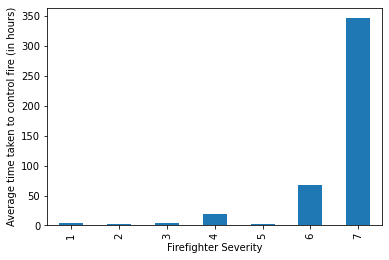

In [7]:
%%time
p4 = p_ffrt_df.drop([3]).sort_values(by="SEVERITY").plot(x="SEVERITY", y="AVG_RSP_TIME", xlabel="Firefighter Severity", ylabel = "Average time taken to control fire (in hours)", kind="bar", legend = False)
fig4 = p4.get_figure()
fig_name = "ff_fire_time.png"
fig4.savefig(f"{IMG_PATH}{fig_name}")

# saving to db
save_in_db(fig_name, "firefighter_severity_vs_fire_time")